# Bacterial growth, linear approximation

In [1]:
import  math
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline, RectBivariateSpline

import ipyvolume as ipv



In [2]:
def Lt(t, T, l_0):
    """
    height of the colony in the microchannel
    as a functio of time
    """
    
    l = l_0*(1+ t/T - math.floor(t/T))
    n = 2**math.floor(t/T)
    
    return n, l, n*l

In [3]:
def plot_data():
    
    n_T = 3
    l_0=1
    T = 20

    t_steps  = [t for  t in range(0, n_T*T)] # 3 periods of T  timesteps
    length = [Lt(t, T, l_0)[2] for t in t_steps]
    plt.figure(figsize=(8,6))
    plt.title('length of the colony in the channel as a function of time for %i periods, %i points each period' %(n_T, T))
    plt.xlabel('timesteps')
    plt.ylabel('colony length, units')
    plt.scatter(t_steps, length,  )
    plt.grid()        

Assuming linear growth of the cell we can  get the lenght of the colony as a  function  of time:

$$L(t)  = 2^{\lfloor t/T \rfloor }l_0(1 +  t/T - \lfloor t/T \rfloor), $$
where $l_0$ -- initial length of the  cell, $T$ -- replication  period, $\lfloor x \rfloor$ -- the floor function.

The graph of the process looks  like:

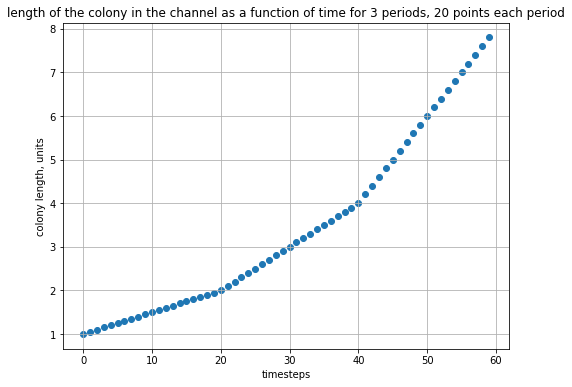

In [4]:
plot_data()

The length of the colony doubles each replication  period, while each individual cell grows from $l_0$ to $2l_0$ when undergoes  division.
As one can see,  the slope of the length curve is  linear between replications, and the slope of  the curve  grows as $2^{\lfloor t/T \rfloor}$.

# An ensemble of channels


In each of the channel, the initial lenght  of the  cell, $l_0$, is a  bit different (mimicking biodiversity), sampled from the normal distribution,  e.g. $N(\mu=1.0, \sigma=0.05)$.

Also  we select  and  _fix_  during the experiment the length of each channel,  $L_{max}$.  As soon as the length of the  colony exceeds $L_{max}$, the  cells being pushed out and flow away (mimicking the lab experiment). 

We observe  how the lengths  of the  cells change as a function of time within one replication period.  

In [5]:
def get_distr_l_0(l_0, k, T):
    """
    returns list of tuples of (n_cell, cell_length)  for a given L_max and l0
    """
    lst =[]
    for t in range(k*T, (k+1)*T):
        n, l, total_length = Lt(t, T, l_0)
        n_L_max  = int(L_max/total_length*n)
#         print(t, n, l, n_L_max)
        lst.append((l, n_L_max))
    return lst

In [6]:
def  run(mu=1.0, sigma=.05, n_channels=100):
    """
    run the experiment
    returns the lists of cell sizes and cell numbers
    """
    global_lst = []
    for l_0 in np.random.normal(mu, sigma, n_channels):
        k = int(math.log2(L_max/(np.abs(l_0)))) +1
        global_lst.append(get_distr_l_0(l_0, k, T))  
        
    flatten_global = [el for sub in global_lst for el in sub]
    x, y = zip(*flatten_global)
    
    return x,y

# Running the experiment

In [7]:
T = 20 # number of timesteps  per period
L_max = 1500 # channel length, units
mu=1.0  # mean of the  initial cell length
sigma=0.02 # std  dev of initila cell length
n_channels = 2500 # number of  channels


After conducting experiment  for ensemble of channels during one replication period we plot the histogram  for observed cell lengths and  number of cells.

Cell length $l=1$ corresponds to the initial  mean value of $l_0=1.0$, the $l=2.0$ corresponds to the mean cell size right before dividing moment.


In [8]:
def plot_hists(n_channels=n_channels, mu=mu, sigma=sigma, L_max=L_max):
    
    x, y = run(mu=mu, sigma=sigma, n_channels=n_channels)
    
    plt.figure(figsize=(16,8))
    plt.suptitle('Distributions for ensemble of %i channels, $\\forall l_0 \in N(\mu=%1.1f, \sigma=%1.3f)$'
                 %(n_channels,mu,sigma), fontsize=16)
    plt.subplot(1,2,1)
    plt.hist(x, bins=50, hatch='.', edgecolor='black')
    plt.title('cell length distribution ')
    plt.xlabel('cell length,  $l$,  units')
    plt.grid()

    plt.subplot(1,2,2)
    plt.hist(y, bins=50, hatch='\\', edgecolor='black', color='red')
    plt.title('number of  cells  distribution within channel of length $L_{max}=$%i'%(L_max))
    plt.xlabel('number of cell')
    plt.grid()

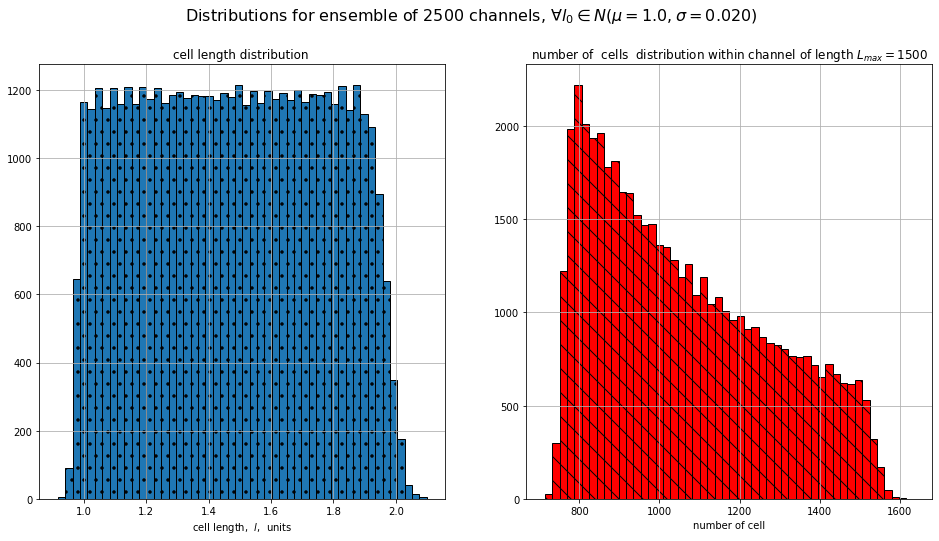

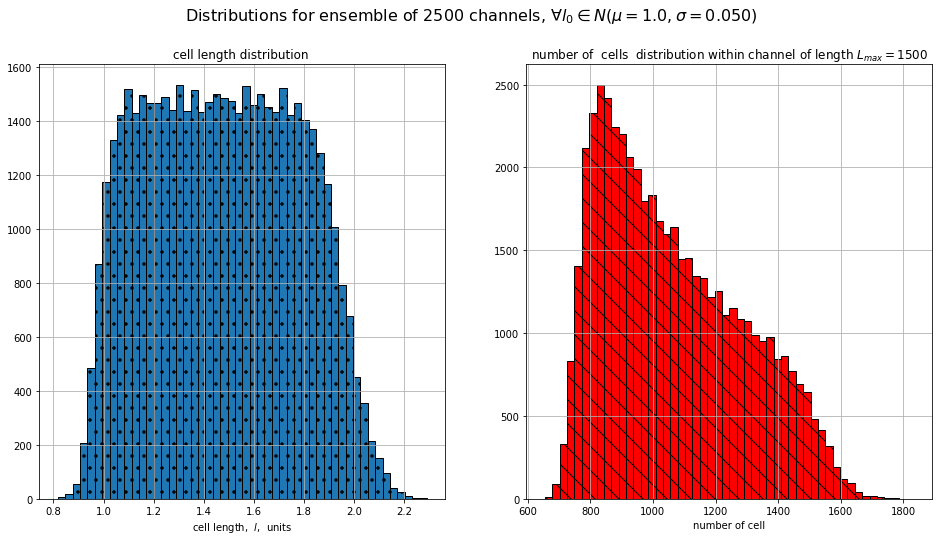

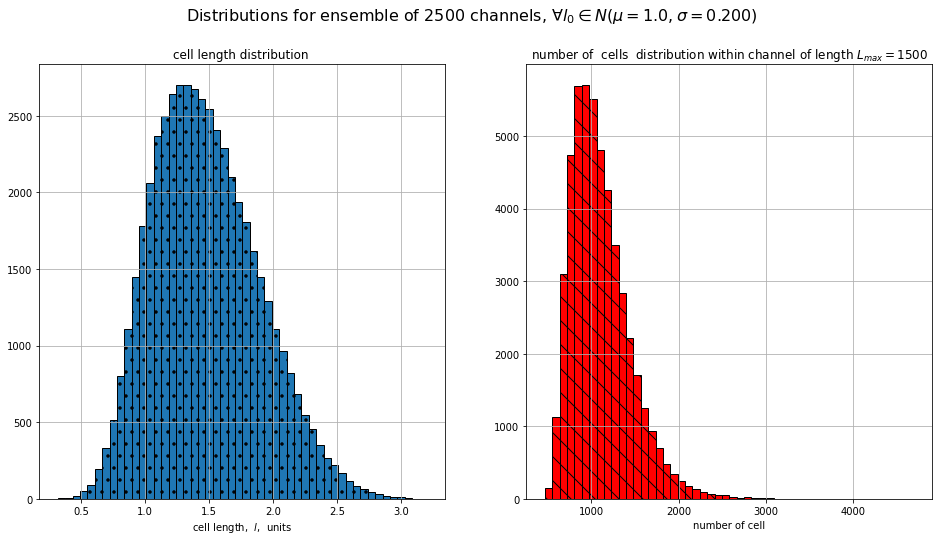

In [9]:
plot_hists()
plot_hists(sigma=0.05)
plot_hists(sigma=0.2)

# Real lab  experiment data analysis `2.1MbpFromOri_rightArm.mat`


In [10]:
annots = loadmat('/Users/alexey/Downloads/2.1MbpFromOri_rightArm.mat')

# annots.keys()

In [11]:
# annots['lengths'].shape

In [12]:
fork_data = pd.DataFrame.from_dict(data = {'areas' : list(annots['areas'].T), 
                                           'lengths': list(annots['lengths'].T),
                                           'longs': list(annots['longs'].T),
                                       
                                          }
                                  ).astype('float')

In [13]:
# fork_data

In [14]:
birth_division_data = pd.DataFrame.from_dict(data = {'birthAreas' : list(annots['birthAreas'].T), 
                                           'divisionAreas': list(annots['divisionAreas'].T),
                                           
                                          }
                                  ).astype('float')
mean_birthArea = birth_division_data['birthAreas'].mean()
mean_divisionArea = birth_division_data['divisionAreas'].mean()

## Area histogram

We use `birthAreas` and `divisionAreas` columns to calculate mean values for those and plot a histogram for cell areas. As  one  can  see in the histogram, the values of areas  for birth and division polulated  nicely.

Were `birthAreas` and `divisionAreas`  obtained  independently of `areas`?


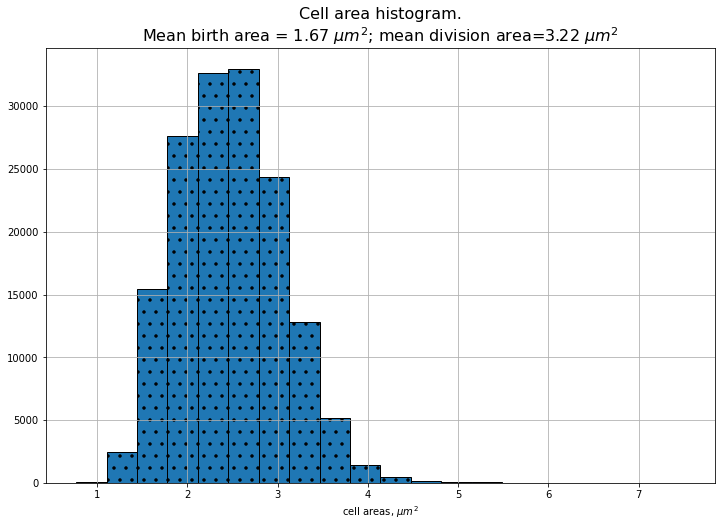

In [15]:
fork_data['areas'].hist(figsize=(12,8), bins=20, hatch='.', edgecolor='black', )
plt.xlabel('cell areas, $\mu m^2$')
# plt.yscale('log')

plt.title("""Cell area histogram.
Mean birth area = %1.2f $\mu m^2$; mean division area=%1.2f $\mu m^2$"""%
          (mean_birthArea, mean_divisionArea), fontsize=16)
plt.show()

## Fork plots

In order to make fork plots we partition area into bins and for each area  bin  plot historgam for `longs` -- normed position along the long cell axis.

By observing the shape of the fork plot one can try to catch the cell  birth stage (maximum at around  `0.5`) and division stage (two  maxima at approximately `0.25`  and  `0.75`).


Here one can see that the birth area is laying somewhere $[2.2\dots  2.4]\, \mu m^2$, and the division area is  around  $4\,\mu m^2$.

This deviates  from the mean values calculated  for  `birthAreas` ($1.67\mu m^2$) and `divisionArea` -- ($3.22\mu m^2$).

In [16]:
n_bins= 20

fork_data['areas_binned'] = pd.cut(fork_data['areas'],  bins=n_bins, )
fork_data['bin_number'] = pd.cut(fork_data['areas'],  bins=n_bins, labels=False)

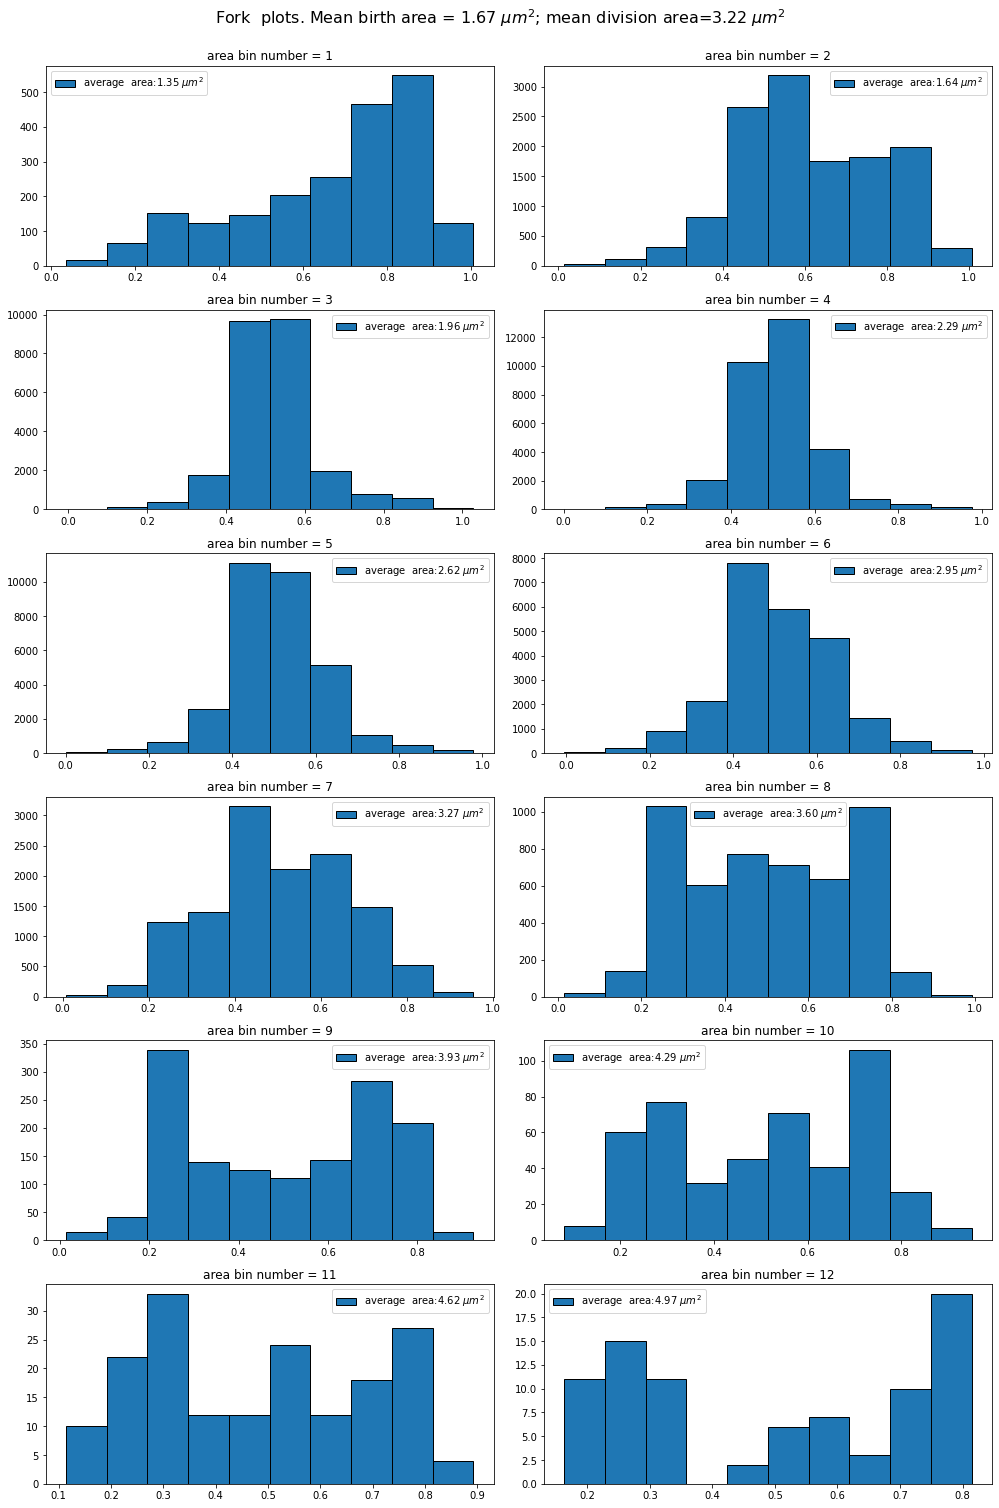

In [17]:
plt.figure(figsize=(14,6*6))
plt.suptitle("""Fork  plots. Mean birth area = %1.2f $\mu m^2$; mean division area=%1.2f $\mu m^2$"""%(mean_birthArea, mean_divisionArea), fontsize=16)


for b in range(1, n_bins-7):
    plt.subplot(n_bins//2,2,b)
    mean_area = fork_data[fork_data['bin_number'] == b]['areas'].mean()
    plt.hist(fork_data[fork_data['bin_number'] == b]['longs'], label='average  area:%1.2f $\mu m^2$'%mean_area, edgecolor='black')
    plt.title('area bin number = %i'%b)
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.show()

# Connecting simulation data   and experimental data

The `lengths` column in the experimental data contains the lenghts of the cells captured during the experiment.
This  gives us an opportunity to try to estimate the  concordance between the simulated and experimental  data.



We will construct the histogram for `lengths` of the cells using the lab data.

Next we  make histogram for lengths of the cells from simulated data for different values of $\sigma$ and $\mu$, and 
find such  pair that minimizes the RMSD between the histograms' values.

In [18]:
def find_best_sigma_mu(lab_data, n_bins=30, s=(0.02,0.5, 5), m=(1.0, 5.0, 10)):
    """
    calculates sigma and mu for best fit for length distribution for simulated  and real lab data
    """

#     min_bin = np.min([np.min(x), np.min(lab_data)])
#     max_bin = np.max([np.max(x), np.max(lab_data)])
#     bins = np.linspace(min_bin, max_bin, n_bins)
    min_bin = np.min(lab_data)
    max_bin =  np.max(lab_data)
    bins = np.linspace(min_bin, max_bin, n_bins)
    vals1, _ = np.histogram(lab_data, density=True, bins=bins)


    
    res = []
    for mu_ in np.linspace(m[0], m[1], m[2]):
#         print(mu_)
        for sigma_ in np.linspace(s[0], s[1], s[2]):
#             print(mu, sigma)
            x, _ = run(mu=mu_, sigma=sigma_, n_channels=5000)
#             x = [el for el in x]
#             x = x - sum(x)/len(x) + lab_data.mean() #centering the data

           

            vals2, _ = np.histogram(x, density=True, bins=bins)

            diff_vals = vals1 - vals2
            diffs = np.dot(diff_vals, diff_vals)

            res.append(diffs)
        
    return res
            


In [19]:
lab_data = fork_data['lengths'].copy()
lab_data = lab_data[lab_data < 7]


s = (0.03, 1., 20)
m=(1.0, 4.0, 20)
res = find_best_sigma_mu(lab_data, n_bins=50, s=s, m=m)



In [20]:
# np.array([1,2,3,4,5,6]).reshape(2,3)

In [21]:
# # diffs =  zip(*res)

# # sigmas = np.array(sigmas).reshape(5,20)

diffs = np.array(res).reshape(m[-1], s[-1])
y = np.linspace(*s)
x = np.linspace(*m)
XX, YY = np.meshgrid(y, x)

# plt.plot_surface(X,Y, diffs)
# diffs.shape, x.shape, y.shape, XX.shape, YY.shape

In [22]:
s2 = RectBivariateSpline(x,y,np.log(diffs),  s=5)


In [39]:
# fig_ipv = ipv.figure()

# ipv.plot_wireframe(XX,YY, s2(x,y), color='blue', )
# ipv.plot_surface(XX, YY, np.log(diffs), )
# # ipv.xlabel('sigma')
# ipv.ylabel('mu')
# ipv.zlabel('difference in log scale')
# ipv.show()
# type(mesh)

## 3D plot  of differences between histograms as  a function of  $\sigma$ and $\mu$.
The mesh has  a clear sigle minimum.
The projection to the flat surface is below.


![ttt](3dsurface.png)


In [24]:
mu_min_index1, sigma_min_index1  = np.unravel_index(s2(x,y).argmin(), s2(x,y).shape)
mu_min_index2, sigma_min_index2  = np.unravel_index(np.log(diffs).argmin(), diffs.shape)


mu_min, sigma_min = x[mu_min_index1], y[sigma_min_index1]

# mu_min_index1, sigma_min_index1, mu_min_index2, sigma_min_index2,sigma_min, mu_min
# sigma_min, mu_min, diffs[mu_min_index, sigma_min_index], s2(mu_min,sigma_min)

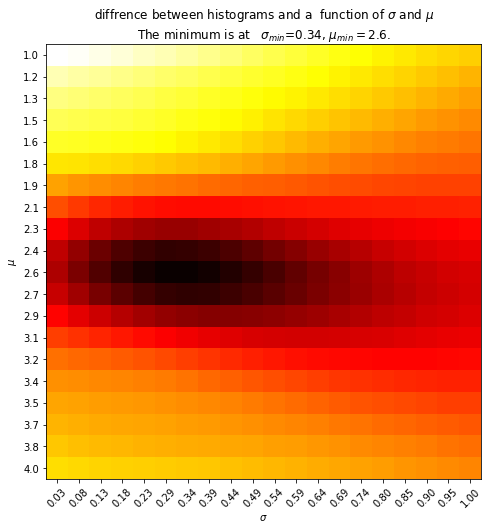

In [25]:
plt.figure(figsize=(12,8))

plt.title("""diffrence between histograms and a  function of $\sigma$ and $\mu$
The minimum is at   $\sigma_{min}$=%1.2f, $\mu_{min}=%1.1f$."""%(sigma_min, mu_min))
plt.imshow(s2(x,y), cmap='hot', interpolation='nearest')
plt.xticks(np.arange(20), ['%1.2f'%el for el in y], rotation=45)
plt.yticks(np.arange(20), ['%1.1f'%el for el in x])
plt.xlabel('$\sigma$')
plt.ylabel("$\mu$")


plt.show()

In [26]:
# s = UnivariateSpline(sigmas, diffs, s=3)

# min_sigma = sigmas[np.argmin(s(sigmas))]

In [27]:
# x, _ = run(mu=10.0, sigma=0.3, n_channels=2500)
# x, y = np.histogram(x, bins=20)
# plt.bar(y[:-1], height=x, width=0.25, edgecolor='red')
# # x,y

In [28]:
# def f(x, a,b,c):
#     """fitting curve"""
    
#     return a*x**2 + b*x + c

# popt, pcov = curve_fit(f, sigmas, diffs)

# popt, type(sigmas)



<!-- ## The Differences between normed histograms with varying $\sigma$.

We use splines to produce a smooth curve, and calculate the best $\sigma$ as the argument which gives minimum to the fit curve.  -->

In [29]:
# plt.figure(figsize=(12,8))
# plt.title('diffs between normed distributions based on noise level $\sigma$')
# plt.xlabel('$\sigma$')
# plt.ylabel('absolute difference')
# plt.scatter(sigmas, diffs, label='differences')
# plt.plot(sigmas, s(sigmas), label =' spline interpolation, $\sigma_{min}=%1.2f$'%min_sigma)
# plt.legend()
# plt.grid()

## Comparing the cell length distributions with the found $\sigma$  and $\mu$.

In [30]:
# x_, y_ = run(mu=2.6, sigma=sigma_min, n_channels=2500)
# x_, y_ = run(mu=mu_min, sigma=sigma_min, n_channels=5000)


# x = x - sum(x)/len(x) + lab_data.mean()
# plt.hist(x_, bins=50, density=True)
# plt.show()

In [31]:
x_, y_ = run(mu=mu_min, sigma=sigma_min, n_channels=5000)


min_bin = np.min(lab_data)
max_bin = np.max(lab_data)
bins = np.linspace(min_bin, max_bin, 50)

v1, b1 = np.histogram(x_, bins=bins, density=True)
v2, b2 = np.histogram(lab_data, bins=bins, density=True)

# print(np.dot(v1 -v2, v1 -v2))
# b1, b2

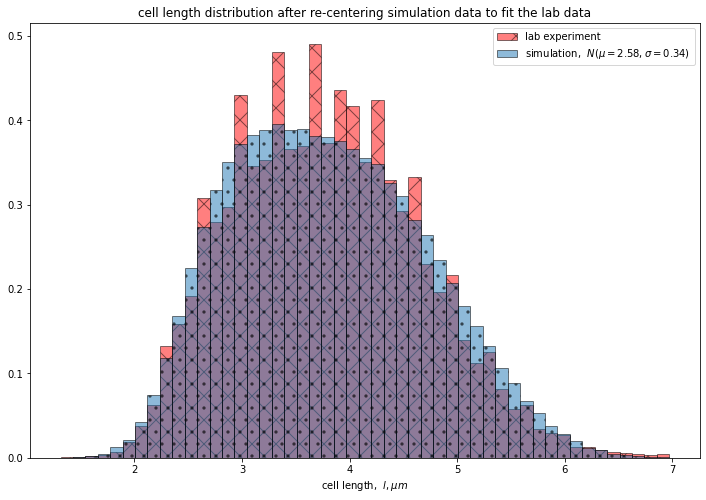

In [32]:
plt.figure(figsize=(12,8))
lab_data.hist( bins=bins, hatch='\/', edgecolor='black', color = 'red', density=True,alpha=.5,
        label='lab experiment')

plt.hist(x_, bins=bins, hatch='.', edgecolor='black', density=True,alpha=.5, 
         label='simulation,  $N( \mu=%1.2f, \sigma=%1.2f)$ '%(mu_min, sigma_min))
plt.title('cell length distribution after re-centering simulation data to fit the lab data')
plt.xlabel('cell length,  $l,\mu m$')
plt.legend()
plt.grid()

# Conclusions


##  Simulations 
In all observed regimes for simulation data (diffent $\sigma$) the cell size distribution plots reveal that the region $[1.0:2.0]$ in length units is decently populated. The difference does not exceed one order  of magnitude.

The  shape of number of  cells distributions also embraces the region from $L_{max}/2$ -- largest cell size just before division to  $L_{max}$ -- the number of newly born cells of $l_0$ length.


## Experiment

The cell area histogram displays  nicely populated range between mean values for `birthArea` and `divisionArea`  ($1.67\mu m^2$ and $3.22\mu m^2$) corrspondingly.

However, while observing the fork plots, the guessed mean `birthArea` and `divisionArea` are shifted: $[2.2\dots  2.4]\, \mu m^2$ and  $\approx 4\,\mu m^2$ correspondingly.


## Fitting simulation and experimental data


The cell grows process in the lab experiment could  be  mimicked to some extent by a simple linear model of cell colony growth within a microchannel. 
The simulation consist of a set of channels, in each of them the initial cell size is drown  from $N(\mu=2.6, \sigma=0.3)$.

In [ ]:
!jupyter nbconvert  bacterial_growth.ipynb --to pdf --no-input && open bacterial_growth.pdf

[NbConvertApp] Converting notebook bacterial_growth.ipynb to pdf
